<a href="https://colab.research.google.com/github/Biglasagna/Repo_test/blob/main/Projet_Diabete_UE_Bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Proposition d'un modèle de deep learning pour la classification patients/contrôles pour le diabète de type 2 à partir de données phénotypiques.
---


## introduction

Le diabète de type

Etapes du code :

* Présentation des données
* Visualisation des données
* Préparation des données
* Création du modèle et entrainement
* Visualisation de l'entrainement
* Test
* Visualisation des résultats

## Chargement des données de l'environnement local vers le drive pour un accès en ligne.




In [1]:
import os
import pandas as pd
import io

# Monter le drive Google (ceci vous demandera d'autoriser l'accès à votre compte)
from google.colab import drive
drive.mount('/content/drive')

# Installer la bibliothèque gdown si ce n'est pas déjà fait
!pip install -q gdown

import gdown

# Extraction de l'ID du fichier depuis l'URL
file_id = '17UIROFJVhc-4sMv9BSEvQ8A7HCI-0kkt'
# Construction de l'URL de téléchargement direct
url = f'https://drive.google.com/uc?id={file_id}'

# Spécifier le chemin de sauvegarde sur le drive personnel
output_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Vérifier si le fichier existe déjà
if not os.path.exists(output_path):
    print("Téléchargement en cours...")
    gdown.download(url, output_path, quiet=False)
else:
    print("Le fichier existe déjà. Téléchargement annulé.")


Mounted at /content/drive
Le fichier existe déjà. Téléchargement annulé.


In [2]:
import pandas as pd
from google.colab import drive

# Step 1: Mount Google Drive to Colab
drive.mount('/content/drive')

# Step 2: Define the path to the file in Google Drive
file_path = '/content/drive/MyDrive/GSE81608_human_islets_rpkm (1).txt'

# Step 3: Load the file into a pandas DataFrame
data = pd.read_csv(file_path, sep='\t')  # Load the file with tab separator
print(data.head(3))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   gene.id  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0        1   47.3396   24.0458    2.2743       0.0       0.0       0.0   
1        2    0.0000    0.0000    0.0000       0.0       0.0       0.0   
2        3    0.0000    0.0000    0.0000       0.0       0.0       0.0   

   Sample_7  Sample_8  Sample_9  ...  Sample_1591  Sample_1592  Sample_1593  \
0       0.0     0.000       0.0  ...          0.0       0.3304       2.4857   
1       0.0     0.254       0.0  ...          0.0       0.0000       0.0000   
2       0.0     0.000       0.0  ...          0.0       0.0000       0.0000   

   Sample_1594  Sample_1595  Sample_1596  Sample_1597  Sample_1598  \
0          0.0       8.1498          0.0       0.5372      31.1225   
1          0.0       0.0000          0.0       0.0000       0.0000   
2          0.0       0.0000          0.0       

## Transformation des données pour garder les "features" (ici les gènes) en colonnes et les individus en ligne, format sur lequel les librairies de deep learning sont basées. Création de la colonne "Label" pour la supervisation de l'apprentissage (0 pour contrôles et 1 pour patients).

In [3]:
# Définir 'gene.id' comme index
data.set_index('gene.id', inplace=True)

data_transposed = data.T  # Transpose the DataFrame
data_transposed['Label'] = [0 if i < 653 else 1 for i in range(len(data_transposed))]

# Verify the transposed data
print(data_transposed.head())

gene.id         1    2    3         9   10   11       12   13        14   15  \
Sample_1  47.3396  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0   31.2047  0.0   
Sample_2  24.0458  0.0  0.0    0.0000  0.0  0.0  14.0425  0.0    0.0000  0.0   
Sample_3   2.2743  0.0  0.0    0.0000  0.0  0.0   0.8412  0.0    7.8214  0.0   
Sample_4   0.0000  0.0  0.0    0.0000  0.0  0.0   0.0000  0.0    0.0000  0.0   
Sample_5   0.0000  0.0  0.0  130.9796  0.0  0.0   0.0000  0.0  120.6832  0.0   

gene.id   ...  101929767  101929768  101929769  101929770  101929771  \
Sample_1  ...     5.1983        0.0        0.0        0.0        0.0   
Sample_2  ...     0.1064        0.0        0.0        0.0        0.0   
Sample_3  ...     0.3188        0.0        0.0        0.0        0.0   
Sample_4  ...     0.0000        0.0        0.0        0.0        0.0   
Sample_5  ...     0.0000        0.0        0.0        0.0        0.0   

gene.id   101930100  102723951  102724004  102724238  Label  
Sample_1       0.00     

## Sur les 40 000 gènes testés par la puce, on ne garde que les 1000 les plus significativement différentiellements exprimés. Pour cela on divise le jeu de données en 2 selon le label pour y effectuer les tests statistiques et ne garder que les gènes avec la meilleure p-value.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Separate patients and controls
patients = data_transposed[data_transposed['Label'] == 1]  # Samples with label 1 (patients)
controls = data_transposed[data_transposed['Label'] == 0]  # Samples with label 0 (controls)

# Remove the 'Label' column for statistical testing
patients = patients.drop(columns=['Label'])
controls = controls.drop(columns=['Label'])

# Initialize a dictionary to store p-values
p_values = {}

# Perform t-test for each gene
for gene in patients.columns:
    t_stat, p_val = ttest_ind(patients[gene], controls[gene], nan_policy='omit')  # Handle NaN values if any
    p_values[gene] = p_val

# Convert p-values to a pandas Series for easier manipulation
p_values_series = pd.Series(p_values)

# Sort genes by p-value (ascending order)
sorted_p_values = p_values_series.sort_values()

# Select the top N genes with the smallest p-values (e.g., top 1000)
top_genes = sorted_p_values.head(10000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']


print(f"Filtered dataset shape: {filtered_data.shape}")


In [ ]:
# Sort genes by p-value (ascending order)
sorted_p_values = p_values_series.sort_values()

# Select the top N genes with the smallest p-values (e.g., top 1000)
top_genes = sorted_p_values.head(30000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']


print(f"Filtered dataset shape: {filtered_data.shape}")
print(filtered_data.head())

In [ ]:
from statsmodels.stats.multitest import multipletests

# Convert p-values to a pandas Series for easier manipulation
p_values_series = pd.Series(p_values)

# Apply Benjamini-Hochberg correction
rejected, corrected_p_values, _, _ = multipletests(p_values_series, alpha=0.05, method='fdr_bh')

# Store corrected p-values in a Series
corrected_p_values_series = pd.Series(corrected_p_values, index=p_values_series.index)

# Sort genes by corrected p-value (ascending order)
sorted_corrected_p_values = corrected_p_values_series.sort_values()

# Select the top N genes with the smallest corrected p-values (e.g., top 1000)
top_genes = sorted_corrected_p_values.head(30000).index  # Adjust the number as needed

# Filter the original dataset to keep only the top differentially expressed genes
filtered_data = data_transposed[top_genes]

# Add the 'Label' column back to the filtered dataset
filtered_data['Label'] = data_transposed['Label']

print(f"Filtered dataset shape: {filtered_data.shape}")

filtered_data.head(5)

Filtered dataset shape: (1600, 30001)


<ipython-input-86-2849cbe4af5b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Label'] = data_transposed['Label']


gene.id,1,2,3,9,10,11,12,13,14,15,...,100189425,100189427,100189428,100189430,100189432,100189433,100189435,100189436,100189437,Label
Sample_1,47.3396,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,31.2047,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Sample_2,24.0458,0.0,0.0,0.0000,0.0,0.0,14.0425,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Sample_3,2.2743,0.0,0.0,0.0000,0.0,0.0,0.8412,0.0,7.8214,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Sample_4,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
Sample_5,0.0000,0.0,0.0,130.9796,0.0,0.0,0.0000,0.0,120.6832,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Création du réseau de neurones.


Epoch [1/5], Loss: 0.6966, Val Loss: 0.5533, Val Accuracy: 73.44%
Epoch [2/5], Loss: 0.2465, Val Loss: 0.4962, Val Accuracy: 76.25%
Epoch [3/5], Loss: 0.1024, Val Loss: 0.4587, Val Accuracy: 77.81%
Epoch [4/5], Loss: 0.0456, Val Loss: 0.4345, Val Accuracy: 79.06%
Epoch [5/5], Loss: 0.0213, Val Loss: 0.4193, Val Accuracy: 80.00%


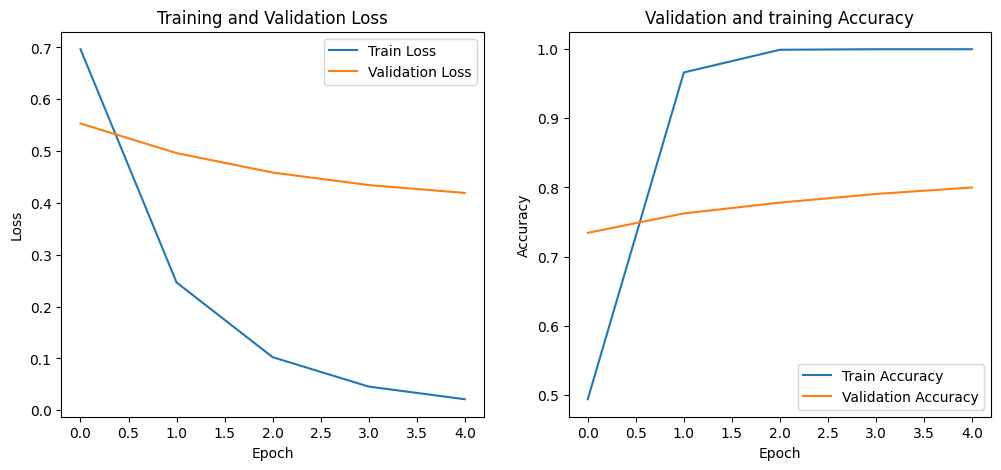

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming your filtered dataset is in a pandas DataFrame called `filtered_data`
X = filtered_data.drop(columns=['Label']).values  # Features (1000 columns)
y = filtered_data['Label'].values  # Labels

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Initialize the model
input_size = X_train.shape[1]  # Number of features (1000)
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1  # Binary classification
model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Calculate training accuracy
    y_train_pred = (outputs > 0.5).float()  # Convertir les probabilités en classes
    train_accuracy = (y_train_pred == y_train).float().mean()  # Calculer l'accuracy
    train_accuracies.append(train_accuracy.item())  # Ajouter à la liste


    # Evaluate on the validation set
    with torch.no_grad():
        model.eval()
        y_pred = model(X_val)
        val_loss = criterion(y_pred, y_val)
        val_losses.append(val_loss.item())

        y_pred_class = (y_pred > 0.5).float()
        accuracy = (y_pred_class == y_val).float().mean()
        val_accuracies.append(accuracy.item())

    # Print loss every 10 epochs
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item() * 100:.2f}%')

# Plot the training and validation loss
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label ='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation and training Accuracy')
plt.legend()

plt.show()

In [ ]:
# Get the weights from the first layer (fc1)
weights = model.fc1.weight.data

# Convert to a numpy array for easier manipulation
weights = weights.numpy()

# Calculate the absolute values of the weights (to measure importance)
weights_abs = np.abs(weights)

# Sum the weights across the hidden units to get a single importance value per feature
feature_importance = np.sum(weights_abs, axis=0)

import matplotlib.pyplot as plt
import numpy as np

# Get the feature names (assuming you have them)
feature_names = filtered_data.drop(columns=['Label']).columns


In [ ]:
# Sort features by importance (descending order)
sorted_indices = np.argsort(feature_importance)[::-1]  # Indices of features sorted by importance
sorted_feature_importance = feature_importance[sorted_indices]  # Sorted importance values
sorted_feature_names = feature_names[sorted_indices]  # Sorted feature names

# Select the top n features
top_n = 1000
top_feature_importance = sorted_feature_importance[:top_n]
top_feature_names = sorted_feature_names[:top_n]

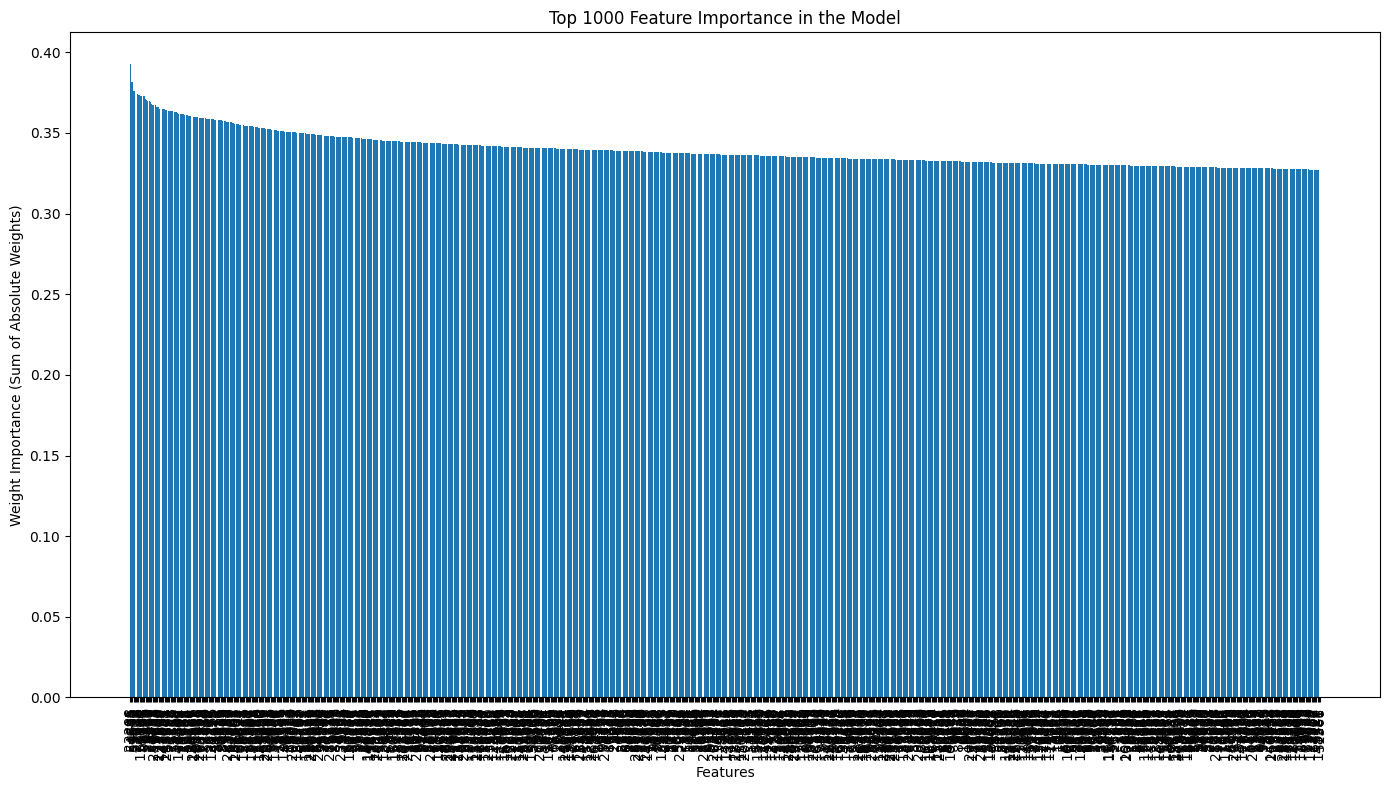

In [ ]:
import matplotlib.pyplot as plt

# Plot the top 1000 features
plt.figure(figsize=(14, 8))
plt.bar(range(top_n), top_feature_importance, align='center')
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight Importance (Sum of Absolute Weights)')
plt.title(f'Top {top_n} Feature Importance in the Model')
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()
